<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw4/hw4_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 758 (delta 1), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (758/758), 117.08 MiB | 24.96 MiB/s, done.
Resolving deltas: 100% (346/346), done.
Checking out files: 100% (129/129), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=16678 sha256=a07c1776dde1b85a1c32ea3c887f9bd9db2e55663fdff34d0385c63ab635b1f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-vgk8e3wu/wheels/f4/4c/b4/9305b2acbe0c658b2b18b21174aa0d2e11245933dbdabdcb71
Successfully built deepul
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# %tensorflow_version 1.x
from deepul.hw4_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')

# Question 1: Warmup [20pt]

In this question, we will train 2 different variants of GANs on an easy 1D dataset. 

Execute the cell below to visualize our datasets.

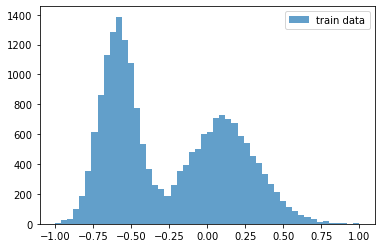

In [3]:
visualize_q1_dataset()

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 



### Solution

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.notebook import tqdm

device = torch.device("cuda")

In [5]:
class MLPGenerator(nn.Module):
    def __init__(self):
        super(MLPGenerator, self).__init__()

        self.seq = nn.Sequential(
            nn.Linear(1, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Tanh(),
        )

    def sample(self, size):
        z = torch.randn(size=(size, 1), device=device)
        return self.seq(z)

class MLPDiscriminator(nn.Module):
    def __init__(self):
        super(MLPDiscriminator, self).__init__()

        self.seq = nn.Sequential(
            nn.Linear(1, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
        )

    def forward(self, X):
        return self.seq(X)


class MLPGan(nn.Module):
    def __init__(self):
        super(MLPGan, self).__init__()

        self.generator = MLPGenerator()
        self.discriminator = MLPDiscriminator()

    def sample(self, size):
        return self.generator.sample(size)

    def logits_real(self, X):
        return self.discriminator(X)


def model_checkpoint(model):
    samples = model.sample(size=5000)
    all_x = torch.linspace(-1, 1, 1000, device=device)[:, None]
    discriminator_out = torch.sigmoid(model.logits_real(all_x))
    return samples.cpu().squeeze(1).detach().numpy(), \
        all_x.cpu().squeeze(1).detach().numpy(), discriminator_out.cpu().squeeze(1).detach().numpy()

In [6]:
def generator_loss(model, X, generated=None):
    if generated is None:
        generated = model.sample(size=X.shape[0])
    return F.logsigmoid(-model.logits_real(generated)).mean()


def discriminator_loss(model, X, generated=None):
    if generated is None:
        generated = model.sample(size=X.shape[0])
    
    return -F.logsigmoid(model.logits_real(X)).mean() - F.logsigmoid(-model.logits_real(generated)).mean()

def calc_loss(model, X):
    generated = model.sample(size=X.shape[0])
    return generator_loss(model, X, generated) + discriminator_loss(model, X, generated)

In [7]:
def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """

    LR = 5e-4
    batch_size = 512
    epochs = 100

    train_data = torch.tensor(train_data, dtype=torch.float, device=device)
    model = MLPGan().to(device)
    g_optimizer = torch.optim.Adam(params=model.generator.parameters(), lr=LR, betas=(0.1, 0.999))
    d_optimizer = torch.optim.Adam(params=model.discriminator.parameters(), lr=LR, betas=(0.1, 0.999))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_losses = []
    
    for epoch in tqdm(range(epochs)):
        for x in train_loader:
            d_loss = discriminator_loss(model, x)
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            g_loss = generator_loss(model, x)
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            train_losses.append((d_loss + g_loss).item())

        if epoch == 1:
            start_check = model_checkpoint(model)

    end_check = model_checkpoint(model)


    return (train_losses, *start_check, *end_check)

### Results

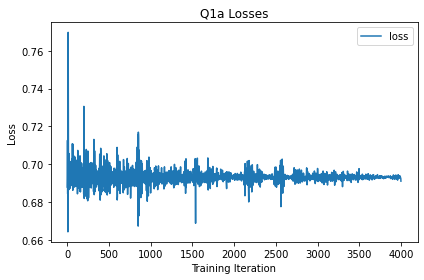

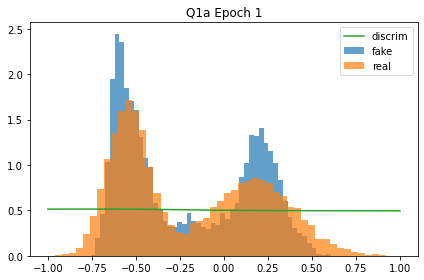

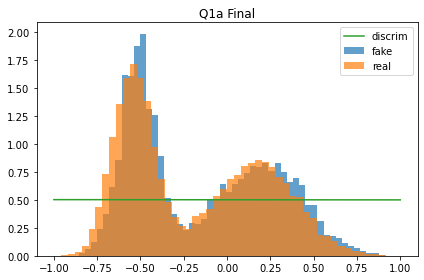

In [8]:
q1_save_results('a', q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate losses:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z))$$

 ### Solution

In [9]:
def generator_loss(model, X, generated=None):
    if generated is None:
        generated = model.sample(size=X.shape[0])
    return -F.logsigmoid(model.logits_real(generated)).mean()


def discriminator_loss(model, X, generated=None):
    if generated is None:
        generated = model.sample(size=X.shape[0])
    
    return -F.logsigmoid(model.logits_real(X)).mean() - F.logsigmoid(-model.logits_real(generated)).mean()

def calc_loss(model, X):
    generated = model.sample(size=X.shape[0])
    return generator_loss(model, X, generated) + discriminator_loss(model, X, generated)

In [10]:
def q1_b(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """
  
    LR = 5e-4
    batch_size = 512
    epochs = 100

    train_data = torch.tensor(train_data, dtype=torch.float, device=device)
    model = MLPGan().to(device)
    g_optimizer = torch.optim.Adam(params=model.generator.parameters(), lr=LR, betas=(0.1, 0.999))
    d_optimizer = torch.optim.Adam(params=model.discriminator.parameters(), lr=LR, betas=(0.1, 0.999))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_losses = []
    
    for epoch in tqdm(range(epochs)):
        for x in train_loader:
            d_loss = discriminator_loss(model, x)
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            g_loss = generator_loss(model, x)
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            train_losses.append((d_loss + g_loss).item())

        if epoch == 1:
            start_check = model_checkpoint(model)

    end_check = model_checkpoint(model)


    return (train_losses, *start_check, *end_check)

 ### Results

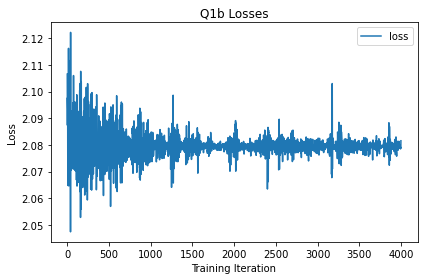

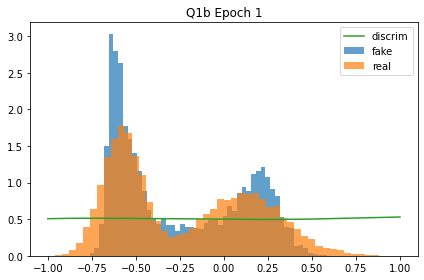

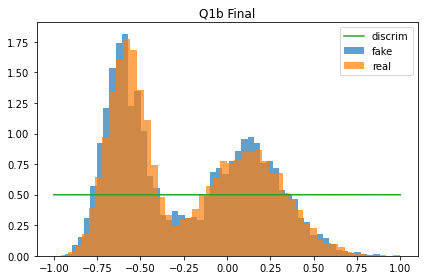

In [11]:
q1_save_results('b', q1_b)

# Question 2: GANs on CIFAR-10 [35pt]

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

Extracting ./data/cifar-10-python.tar.gz to ./data



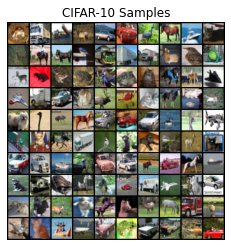

In [12]:
visualize_q2_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Fréchet inception distance (bonus, 5pts)
3. Discriminator loss across training
4. 100 samples. 

In [13]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size
 
    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width, s_depth)
        output = output.permute(0, 3, 1, 2)
        return output
 
 
class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size
 
    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output
 
# Spatial Upsampling with Nearest Neighbors
class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.depth2space = DepthToSpace(2)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = torch.cat([x, x, x, x], dim=1)
        x = self.depth2space(x)
        x = self.conv(x)
        return x
 

# Spatial Downsampling with Spatial Mean Pooling
class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.space2depth = SpaceToDepth(2)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = self.space2depth(x)
        x = sum(x.chunk(4, dim=1)) / 4.0
        x = self.conv(x)
        return x

In [14]:
class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.seq = nn.Sequential(
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU()
        )

        self.upsample_a = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
        self.upsample_b = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        y = self.seq(x)
        residual = self.upsample_a(y)
        shortcut = self.upsample_b(x)
        return residual + shortcut

class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.seq = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.ReLU()
        )
    
        self.downsample_a = Downsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
        self.downsample_b = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        y = self.seq(x)
        residual = self.downsample_a(y)
        shortcut = self.downsample_b(x)
        return residual + shortcut

In [15]:
class ReshapeLayer(nn.Module):
    def __init__(self, new_shape):
        super().__init__()
        self.new_shape = new_shape

    def forward(self, x):
        return x.reshape(self.new_shape)

class Generator(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(128, 4 * 4 * 256),
            ReshapeLayer((-1, 256, 4, 4)),
            ResnetBlockUp(in_dim=256, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
            nn.Tanh()
        )


    def sample(self, n_samples):
        z = torch.randn(size=(n_samples, 128), device=device)
        return self.seq(z)
    
# discriminator as in original WGAN-GP paper
# just changing Up <-> Down and removing BatchNorm from Generator architecture leads to less cool results
class ResBlock(nn.Module):
    def __init__(self, in_dim, n_filters=128):
        super().__init__()
        self.seq = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size=(3, 3), padding=1)
        )

    def forward(self, x):
        y = self.seq(x)
        return x + y

class Discriminator(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.seq = nn.Sequential(
            ResnetBlockDown(in_dim=3, n_filters=n_filters),
            ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
            ResBlock(n_filters),
            ResBlock(n_filters),
            nn.ReLU()
        )
        self.fc = nn.Linear(128, 1)

    def estimate(self, x):
        x = self.seq(x)
        assert(x.shape[1] == 128 and x.shape[2] == 8 and x.shape[3] == 8)
        x = torch.sum(x, dim=(2, 3))
        x = self.fc(x)
        return x


class WGAN_GP(nn.Module):
    def __init__(self):
        super().__init__()

        self.generator = Generator()
        self.discriminator = Discriminator()

    def sample(self, size):
        return self.generator.sample(size)

    def estimate(self, X):
        return self.discriminator.estimate(X)

In [16]:
LR = 2e-4
batch_size = 256
epochs = 150
lam = 10
n_disc = 5

In [17]:
a = torch.arange(10, dtype=torch.float)
a.requires_grad_()

b = a * a

gradients = torch.autograd.grad(b, a, torch.ones_like(b))
gradients

(tensor([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.]),)

In [18]:
# Achtung, resets gradient in discriminator
def get_grad_penalty(model, generated):
    model.discriminator.zero_grad()
    values = model.estimate(generated).squeeze(1)
    gradients = torch.autograd.grad(values, generated, torch.ones_like(values), create_graph=True)[0]
    gradient_norms = torch.sqrt(torch.sum(gradients ** 2, dim=(1, 2, 3)))

    assert(len(gradient_norms.shape) == 1)

    return ((gradient_norms - 1) ** 2).mean()


def discriminator_loss(model, X):
    with torch.no_grad():
        generated = model.sample(X.shape[0])
    eps = torch.rand((X.shape[0], 1, 1, 1), device=device)
    soft_generated = eps * X + (1 - eps) * generated
    soft_generated.requires_grad_()
    gradient_penalty = get_grad_penalty(model, soft_generated)
    return model.estimate(generated).mean() - model.estimate(X).mean() + lam * gradient_penalty


def generator_loss(model, size):
    generated = model.sample(size)
    return -model.estimate(generated).mean()

## Solution

In [19]:
def q2(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    train_data = torch.tensor(train_data, dtype=torch.float, device=device) * 2 - 1
    model = WGAN_GP().to(device)
    g_optimizer = torch.optim.Adam(params=model.generator.parameters(), lr=LR, betas=(0., 0.9))
    d_optimizer = torch.optim.Adam(params=model.discriminator.parameters(), lr=LR, betas=(0., 0.9))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    g_scheduler = torch.optim.lr_scheduler.OneCycleLR(g_optimizer, max_lr=LR,
                                                      steps_per_epoch=len(train_loader), epochs=epochs, pct_start=0.01, anneal_strategy='linear',
                                                      max_momentum=0.0, base_momentum=0.0)
    d_scheduler = torch.optim.lr_scheduler.OneCycleLR(d_optimizer, max_lr=LR,
                                                      steps_per_epoch=len(train_loader), epochs=epochs, pct_start=0.01, anneal_strategy='linear',
                                                      max_momentum=0.0, base_momentum=0.0)
    train_losses = []
    disc_losses = []

    model.train()
    for epoch in tqdm(range(epochs)):
        for i, x in enumerate(train_loader):
            d_loss = discriminator_loss(model, x)
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            if i % n_disc == 0:
                g_loss = generator_loss(model, x.shape[0])
                g_optimizer.zero_grad()
                g_loss.backward()
                g_optimizer.step()
            else:
                g_loss = 0

            d_scheduler.step()
            g_scheduler.step()
            disc_losses.append(d_loss.item())
            train_losses.append((d_loss + g_loss).item())

    model.eval()
    with torch.no_grad():
        samples = model.sample(1000) * 0.5 + 0.5

    return np.array(disc_losses), samples.cpu().detach().numpy().transpose(0, 2, 3, 1)

## Results

Files already downloaded and verified



..........Inception score: 6.9087815


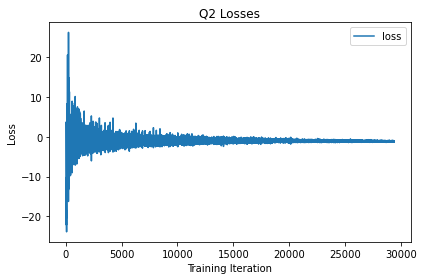

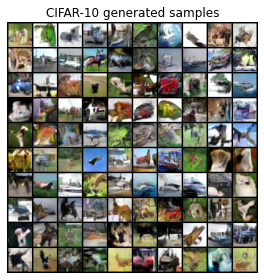

In [20]:
q2_save_results(q2)

# Question 3: Representation Learning with BiGAN on MNIST [45pt]

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!



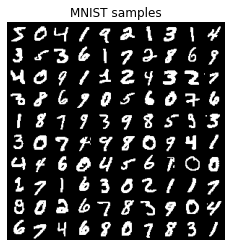

In [21]:
visualize_q3_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


## Solution

In [22]:
class Encoder(nn.Module):
    def __init__(self, in_sz, out_sz):
        super(Encoder, self).__init__()

        self.seq = nn.Sequential(
            nn.Linear(in_sz, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, out_sz)
        )

    def forward(self, x):
        return self.seq(x)

class Generator(nn.Module):
    def __init__(self, in_sz, out_sz):
        super(Generator, self).__init__()

        self.z_sz = in_sz

        self.seq = nn.Sequential(
            nn.Linear(in_sz, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.ReLU(inplace=True),
            nn.Linear(1024, out_sz),
            nn.Tanh()
        )

    def forward(self, x):
        return self.seq(x)

    def generate(self, n):
        z = torch.randn(size=(n, self.z_sz)).to(device)
        return self.forward(z)

class Discriminator(nn.Module):
    def __init__(self, x_sz, z_sz):
        super(Discriminator, self).__init__()

        self.seq = nn.Sequential(
            nn.Linear(x_sz + z_sz, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x, z):
        return self.seq(torch.cat([x, z], dim=1))

In [23]:
class BiGAN(nn.Module):
    def __init__(self, z_sz, x_sz):
        super(BiGAN, self).__init__()

        self.z_sz = z_sz
        self.x_sz = x_sz
        self.encoder = Encoder(x_sz, z_sz)
        self.generator = Generator(z_sz, x_sz)
        self.discriminator = Discriminator(x_sz, z_sz)

    

In [24]:
def calc_loss(model, x):
    bsz = x.shape[0]
    z = torch.randn(size=(bsz, 50)).to(device)
    gx = model.generator(z)
    ez = model.encoder(x.view(bsz, -1))
    
    return F.logsigmoid(model.discriminator(x.view(bsz, -1), ez)).mean() + F.logsigmoid(-model.discriminator(gx, z)).mean()

In [25]:
class LinearClassifier(nn.Module):
    def __init__(self, z_sz):
        super(LinearClassifier, self).__init__()

        self.fc = nn.Linear(z_sz, 10)
        self.optimizer = torch.optim.Adam(self.fc.parameters(), lr=1e-3)

    def train(self, encoder, train_data, test_data):
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

        losses = list()
        for epoch in tqdm(range(50)):
            for (x, y) in train_loader:
                x, y = x.to(device), y.to(device)
                with torch.no_grad():
                    e = encoder(x.view(-1, 784))
                loss = F.cross_entropy(self.fc(e), y)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            sum_loss, cnt = 0, 0
            for (x, y) in test_loader:
                x, y = x.to(device), y.to(device)
                with torch.no_grad():
                    e = encoder(x.view(-1, 784))
                    loss = F.cross_entropy(self.fc(e), y)
                    sum_loss += loss.item()
                    cnt += 1
            losses.append(sum_loss / cnt)
        return losses

In [26]:
import itertools

LR = 2e-4
batch_size = 512
epochs = 300

def q3(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    """ YOUR CODE HERE """


    model = BiGAN(50, 784).to(device)
    g_optimizer = torch.optim.Adam(params=itertools.chain(model.generator.parameters(), model.encoder.parameters()),
                                                          lr=LR, betas=(0.5, 0.999), weight_decay=2.5e-5)
    d_optimizer = torch.optim.Adam(params=model.discriminator.parameters(), lr=LR, betas=(0.5, 0.999), weight_decay=2.5e-5)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    g_scheduler = torch.optim.lr_scheduler.OneCycleLR(g_optimizer, max_lr=LR,
                                                      steps_per_epoch=len(train_loader), epochs=epochs, pct_start=0.01, anneal_strategy='linear', 
                                                      max_momentum=0.5, base_momentum=0.5)
    d_scheduler = torch.optim.lr_scheduler.OneCycleLR(d_optimizer, max_lr=LR,
                                                      steps_per_epoch=len(train_loader), epochs=epochs, pct_start=0.01, anneal_strategy='linear',
                                                      max_momentum=0.5, base_momentum=0.5)
    train_losses = []
    disc_losses = []

    model.train()
    for epoch in tqdm(range(epochs)):
        for i, (x, y) in enumerate(train_loader):
            d_loss = -calc_loss(model, x.to(device))
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            g_loss = calc_loss(model, x.to(device))
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()


            d_scheduler.step()
            g_scheduler.step()
            disc_losses.append(d_loss.item())
            train_losses.append((d_loss + g_loss).item())

    model.eval()
    with torch.no_grad():
        samples = model.generator.generate(100) * 0.5 + 0.5
        samples = samples.reshape(-1, 28, 28, 1).detach().cpu().numpy()

        x = (test_data.data[:20].to(device) / 255.) * 2 - 1
        ez = model.encoder(x.view(20, 784))
        gx = model.generator(ez).reshape(20, 28, 28, 1)
        recon_pairs = torch.cat([x.unsqueeze(3), gx], dim=1) * 0.5 + 0.5
        recon_pairs = recon_pairs.detach().cpu().numpy()

    a = LinearClassifier(50).to(device)
    b = LinearClassifier(50).to(device)

    losses_a = a.train(model.encoder, train_data, test_data)
    losses_b = b.train(Encoder(784, 50).to(device), train_data, test_data)

    return -np.array(disc_losses), samples, recon_pairs, np.array(losses_a), np.array(losses_b)

## Results

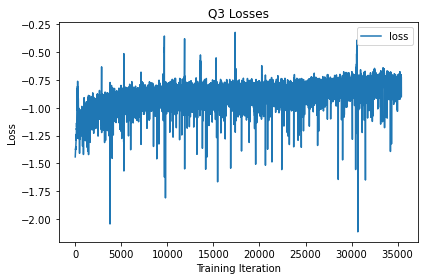

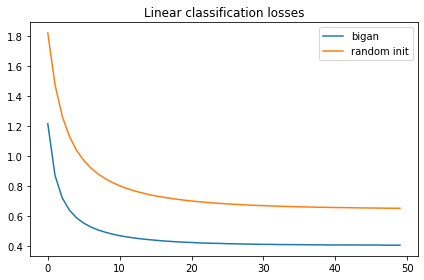

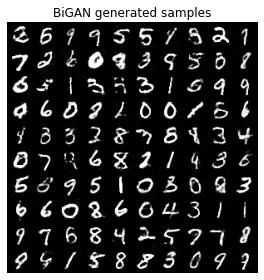

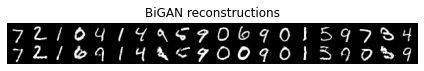

BiGAN final linear classification loss: 0.4086489364504814
Random encoder linear classification loss: 0.6539129987359047


In [27]:
q3_save_results(q3)

# Question 4 (Bonus): CycleGAN [20pt]
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

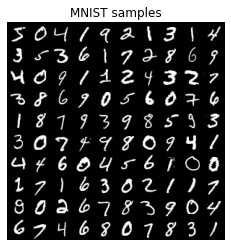

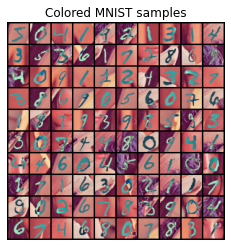

In [28]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [29]:
class SmallGeneratorNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SmallGeneratorNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, out_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.seq(x)

class SmallDiscriminatorNet(nn.Module):
    def __init__(self, in_channels):
        super(SmallDiscriminatorNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(start_dim=1),
            nn.Linear(2048, 1)
        )

    def forward(self, x):
        return self.seq(x)



In [30]:
def mathGANLoss(X_true, X_false):
    return (F.logsigmoid(X_true) + F.logsigmoid(-X_false)).mean()

def classicGANLoss(X_true, X_false):
    return (F.logsigmoid(X_true) - F.logsigmoid(X_false)).mean()

# as in paper
def MSEGanLoss(X_true, X_false):
    return ((X_true - 1) ** 2 + X_false ** 2).mean()

def reconstructionLoss(X, X_recon):
    return torch.abs(X - X_recon).mean(dim=(1, 2, 3)).mean(dim=0)


In [31]:
device = torch.device("cuda")
BATCH_SIZE = 128 # more better ? batch_size=1 ?
LR = 2e-4
epochs = 100
n_disc = 1 # try != 1?

ADAM_BETA = (0.5, 0.999)
recon_lam = 10

In [32]:
# many training tricks like buffer for discriminator were removed for simplicity
class CycleGAN(nn.Module):
    def __init__(self):
        super(CycleGAN, self).__init__()

        self.discriminator_X = SmallDiscriminatorNet(1).to(device)
        self.discriminator_Y = SmallDiscriminatorNet(3).to(device)

        self.generator_X = SmallGeneratorNet(3, 1).to(device)
        self.generator_Y = SmallGeneratorNet(1, 3).to(device)

        self.optimizer_discriminators = torch.optim.Adam(
                itertools.chain(self.discriminator_X.parameters(), self.discriminator_Y.parameters()),
                lr=LR,
                betas=ADAM_BETA
        )

        self.optimizer_generators = torch.optim.Adam(
                itertools.chain(self.generator_X.parameters(), self.generator_Y.parameters()),
                lr=LR,
                betas=ADAM_BETA
        )
        self.g_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer_generators, max_lr=LR,
                                                      steps_per_epoch=60000//128 + 1, epochs=epochs, pct_start=0.05, anneal_strategy='linear',
                                                      max_momentum=0.5, base_momentum=0.5)
        self.d_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer_discriminators, max_lr=LR,
                                                      steps_per_epoch=60000//128 + 1, epochs=epochs, pct_start=0.05, anneal_strategy='linear',
                                                      max_momentum=0.5, base_momentum=0.5)
    
    
    def translate_XY(self, X):
        with torch.no_grad():
            return self.generator_Y(X * 2 - 1) * 0.5 + 0.5

    def translate_YX(self, Y):
        with torch.no_grad():
            return self.generator_X(Y * 2 - 1) * 0.5 + 0.5

    def disc_loss(self, X, Y):
        X_generated = self.generator_X(Y)
        Y_generated = self.generator_Y(X)

        X_true, X_false = self.discriminator_X(X), self.discriminator_X(X_generated)
        Y_true, Y_false = self.discriminator_Y(Y), self.discriminator_Y(Y_generated)

        disc_loss = MSEGanLoss(X_true, X_false) + MSEGanLoss(Y_true, Y_false)
        return disc_loss


    def gen_loss(self, X, Y):
        X_generated = self.generator_X(Y)
        Y_generated = self.generator_Y(X)

        X_true, X_false = self.discriminator_X(X), self.discriminator_X(X_generated)
        Y_true, Y_false = self.discriminator_Y(Y), self.discriminator_Y(Y_generated)

        X_reconstructed = self.generator_X(Y_generated)
        Y_reconstructed = self.generator_Y(X_generated)

        gen_loss = MSEGanLoss(X_false, X_true) + MSEGanLoss(Y_false, Y_true)
        recon_loss = recon_lam * (reconstructionLoss(X, X_reconstructed) + reconstructionLoss(Y, Y_reconstructed))

        return gen_loss + recon_loss


    def train(self, X_data, Y_data):
        X_data = 2 * X_data - 1
        Y_data = 2 * Y_data - 1

        X_loader = torch.utils.data.DataLoader(X_data.to(device), batch_size=BATCH_SIZE, shuffle=True) 
        Y_loader = torch.utils.data.DataLoader(Y_data.to(device), batch_size=BATCH_SIZE, shuffle=True) 

        losses = list()

        for epoch in tqdm(range(epochs)):
            for i, (X, Y) in enumerate(zip(X_loader, Y_loader)):
                disc_loss = self.disc_loss(X, Y)

                self.optimizer_discriminators.zero_grad()
                disc_loss.backward()
                self.optimizer_discriminators.step()

                if i % n_disc == 0:
                    gen_loss = self.gen_loss(X, Y)
                    self.optimizer_generators.zero_grad()
                    gen_loss.backward()
                    self.optimizer_generators.step()
                else:
                    gen_loss = 0

                self.g_scheduler.step()
                self.d_scheduler.step()
                losses.append((disc_loss + gen_loss).item())

        return losses


In [33]:
device = torch.device("cuda")
import itertools
from tqdm.notebook import tqdm
%matplotlib inline 
import matplotlib.pyplot as plt

def q4(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """

    mnist_data = torch.from_numpy(mnist_data).float().to(device)
    cmnist_data = torch.from_numpy(cmnist_data).float().to(device)

    model = CycleGAN()
    losses = model.train(mnist_data, cmnist_data)

    plt.plot(losses)
    plt.show()

    X = mnist_data[:20]
    tX = model.translate_XY(X)
    rX = model.translate_YX(tX)

    Y = cmnist_data[:20]
    tY = model.translate_YX(Y)
    rY = model.translate_XY(tY)

    def out(ts):
        return (t.detach().cpu().numpy().transpose(0, 2, 3, 1) for t in ts)

    return out((X, tX, rX, Y, tY, rY))

## Results

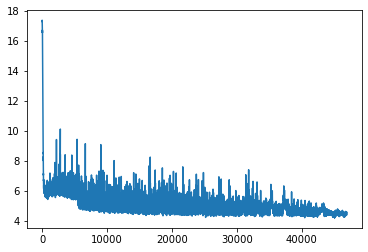

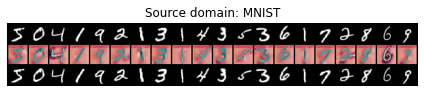

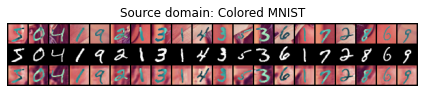

In [34]:
q4_save_results(q4)